In [1]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import dynamo as dyn
import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn import preprocessing

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
def plot_X(X, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.scatter(X[:, dim1], X[:, dim2], **kwargs)
    
def plot_V(X, V, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.quiver(X[:, dim1], X[:, dim2], V[:, dim1], V[:, dim2])
    
def color_set(data,gene):
    gene_idx=np.where(data.var_names==gene)[0][0]
    c=np.squeeze(np.asarray(data.X[:,gene_idx].todense()))
    return c

def color_treatment(adata):
    le=preprocessing.LabelEncoder()
    treatment=adata.obsm['treatment']
    uniq_labels=np.unique(treatment)
    labels=le.fit(uniq_labels)
    classes=le.classes_
    encoded=le.transform(treatment)
    print(le.get_params())
    return encoded,le

def simulation(tr,num_trajectories,init_probs,final_states):
    #using list because trajectories can be different sizes
    traj_list=[]
    for traj in range(num_trajectories):
        #uses init probabilities to find the initial state
        boolean=np.cumsum(p0)<=np.random.uniform()
        state=np.where(boolean==False)[0][0]
        #appends the first state to the traj list
        traj_list.append(np.array([state]))
        while state not in final_states:
            boolean_list=np.cumsum(tr.P[:,state].data)<=np.random.uniform()
            state=int(tr.Idx[state][np.where(boolean_list==False)[0][0]])
            traj_list[traj]=np.append(traj_list[traj],state)

    return traj_list

In [3]:
adata=dyn.read_h5ad('met/a549_tgfb1_met_processed.h5ad')
P=np.loadtxt('met/a549_tgfb1_met_P.npy')
Idx=np.load('met/a549_tgfb1_met_idx.npy',allow_pickle=True)

In [4]:
kmc=dyn.tl.KernelMarkovChain(P=P,Idx=Idx)

X = adata.layers['M_s'][:, adata.var['use_for_velocity']]
V = adata.layers['velocity_S'][:, adata.var['use_for_velocity']]
#X_emb = adata.obsm['X_pca']
X_emb = adata.obsm['X_umap']

Uc = kmc.compute_density_corrected_drift(X_emb, normalize_vector=True)

sd = kmc.compute_stationary_distribution()

U_grid, X_grid = dyn.tl.smoothen_drift_on_grid(X_emb[:, :2], Uc[:, :2], 30, k=50, smoothness=0.5)

calculating density corrected drift: 100%|██████████| 435/435 [00:00<00:00, 2836.62it/s]


{}


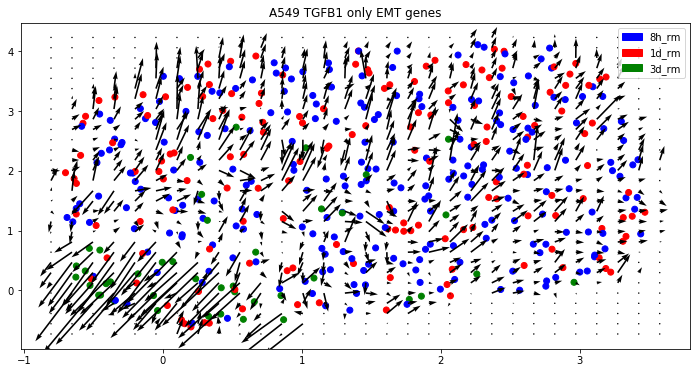

In [7]:
colors,le=color_treatment(adata)

colors=np.divide(colors,2).astype('str')

colors[colors=="1.0"]='b'
b=mpatches.Patch(color='b',label='8h_rm')

colors[colors=="0.0"]='r'
r=mpatches.Patch(color='r',label='1d_rm')

colors[colors=="0.5"]='g'
g=mpatches.Patch(color='g',label='3d_rm')


plot_X(X_emb, create_figure=True, figsize=(12, 6),color=colors)

plt.legend(handles=[b,r,g])

plt.title('A549 TGFB1 only EMT genes')

plot_V(X_grid, U_grid, facecolor='k')

In [6]:
colors,le=color_treatment(adata)

set([(value,treatment) for value,treatment in zip(colors/2,adata.obsm['treatment']) ])

{}


{(0.0, '1d_rm'), (0.5, '3d_rm'), (1.0, '8h_rm')}

In [15]:
set(colors/4)

{0.0, 0.25, 0.5, 0.75, 1.0}